In [3]:
from __future__ import print_function, division

In [4]:
# import libraries
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import scale
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
# update your data path
DATA_PATH = "/home/aunagar/Personal/Study/Sem1/Advanced ML/projects/task1/Task1/"

In [6]:
# import data
train_X = pd.read_csv(DATA_PATH + "X_train.csv")
train_Y = pd.read_csv(DATA_PATH + "y_train.csv")
test_X = pd.read_csv(DATA_PATH + "X_test.csv")
sample_submission = pd.read_csv(DATA_PATH + "sample.csv")

In [7]:
# split data
train_ids = train_X.iloc[:, 0]
train_features = train_X.iloc[:, 1:]
test_ids = test_X.iloc[:, 0]
test_features = test_X.iloc[:, 1:]

In [8]:
######## missing value imputation (median) ########
# train
train_features = train_features.fillna(train_features.mean())
# test
test_features = test_features.fillna(train_features.mean())


####### limiting feature using variance threshold (i.e. remove features with 0 variance) ######
train_features_mean, train_features_std = train_features.mean(), train_features.std()

train_features = train_features.iloc[:, np.where(train_features_std > 0.0)[0]]
test_features = test_features.iloc[:, np.where(train_features_std > 0.0)[0]]

############## Outlier removal ###############
train_features_mean, train_features_std = train_features.mean(), train_features.std()
# train
train_features[train_features > train_features_mean + 2*train_features_std] = np.nan
train_features[train_features < train_features_mean -2*train_features_std] = np.nan
train_features = train_features.fillna(train_features.mean())

# test
test_features[test_features > train_features_mean + 2*train_features_std] = np.nan
test_features[test_features < train_features_mean - 2*train_features_std] = np.nan
test_features = test_features.fillna(train_features.mean())

In [9]:
##### Normalization #####
# train
train_mean, train_std = train_features.mean(), train_features.std()
train_features = (train_features - train_mean)/train_std
# test 
test_features = (test_features - train_mean)/train_std

In [10]:
###### Correlated feature removal #########
# Create correlation matrix
corr_matrix = train_features.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# train
train_features = train_features.drop(columns = to_drop)
# test
test_features = test_features.drop(columns = to_drop)

In [11]:
# ##### correlation with respect to Y #######
# corr_values = train_features.corrwith(train_Y['y'], axis = 0)

# # Find index of feature columns with correlation greater than 0.7
# to_drop = [column for column in corr_values.index if corr_values.loc[column] < 0.01]

In [19]:
###### linear model
lr = ElasticNet(alpha = 0.5, l1_ratio=0.5)
validation_score = cross_val_score(lr, train_features, train_Y.iloc[:, 1:], cv = 5, scoring = 'r2')
print(validation_score.mean())

# train model on whole train data
lr.fit(X = train_features, y = train_Y.iloc[:, 1])

0.5015512214114571


ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

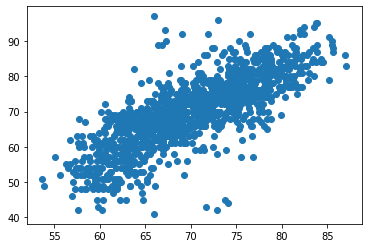

In [20]:
plt.scatter(lr.predict(train_features), train_Y.iloc[:, 1].values)
plt.show()

In [13]:
# finding to which features to remove
non_zero_weights = np.where(lr.coef_ != 0.)[0]

# removing these features from training data
train_features = train_features.iloc[:, non_zero_weights]
test_features = test_features.iloc[:, non_zero_weights]

In [82]:
#### training 
hr = HuberRegressor(epsilon=2.3, max_iter=100, alpha=2, warm_start=False, fit_intercept=True, tol=1e-05)
validation_score = cross_val_score(hr, train_features, train_Y.iloc[:, 1:].values.reshape(-1), cv = 5, scoring = 'r2')
print(validation_score.mean())

# train model on whole train data
hr.fit(X = train_features, y = train_Y.iloc[:,1].values.reshape(-1))

0.5521126137838073


HuberRegressor(alpha=2, epsilon=2.3, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [83]:
sum(hr.outliers_)

45

In [30]:
#### training more complex model on this cleared data
rfr = RandomForestRegressor(n_estimators=1000, max_depth=15)
validation_score = cross_val_score(rfr, train_features, train_Y.iloc[:, 1], cv = 5, scoring= 'r2')
print(validation_score.mean())

rfr.fit(X= train_features, y = train_Y.iloc[:, 1].values)

0.5142450678016455


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [84]:
best_model = hr

In [85]:
predicted = best_model.predict(test_features)
sample_submission['y'] = predicted

In [86]:
sample_submission.to_csv("submissions/Ajay_6th_sub.csv", index = False)